In [9]:
import matplotlib.pyplot as plt
from utils.graph import Graph
from pareto_set import ParetoSet
from pareto_set import BiObjSolution as sol
from ipywidgets import interact, widgets
from search_tree_pqd import SearchTreePQD, Node
from collections import defaultdict
from heapq import heapify, heappop, heappush
from typing import Optional
from graph_visualization import visualize_graph

# ParetoSet

In [10]:
from pareto_set import Solution


class BiObjSolution(Solution):
    def __init__(self, solution_values):
        self.solution_values = solution_values
        self.x = solution_values[0]
        self.y = solution_values[1]
        self.g2 = self.y

    def is_dominated_by(self, other: 'BiObjSolution'):
        return not self.is_dominates(other)
    
    def is_dominates(self, other):
        return (self.x < other.x and self.y <= other.y) or (self.x <= other.x and self.y < other.y)
    
    def __str__(self):
        return f"({self.x}, {self.y})"
    
    def __hash__(self) -> int:
        return hash((self.x, self.y))
    
    def __repr__(self) -> str:
        return f"BiObjSolution([{self.x}, {self.y}])"
    
    def __eq__(self, another_solution) -> bool:
        return self.x == another_solution.x and self.y == another_solution.y

In [11]:
class ParetoSet:
    def __init__(self, SolutionClass=BiObjSolution):
        self.history = []
        self.solutions = set()
        self.SolutionClass = SolutionClass
        self.g2min = float('inf')

        #Для визуализации
        self.max_y = 0
        self.max_x = 0
        self.all_solusions_ever = set()

    def add_solution(self, solution_values):
        #TODO: можно набирать вершины в новый Парето-сет одновременно с проверкой того, будем ли вообще добавлять решение
        solution = self.SolutionClass(solution_values)
        
        #Для визуализации
        self.all_solusions_ever.add(solution)

        if self.g2min > solution.g2:
            self.solutions.add(solution)
            self.g2min = solution.g2

    def del_solution(self, solution_values):
        solution = self.SolutionClass(solution_values)
        self.solutions.remove(solution)

    def get_solutions(self):
        return self.solutions

    def dominates_by(self, solution_values):
        return self.g2min <= solution_values[1]
    
    def visualize(self):
        solutions = self.get_solutions()
        if not solutions:
            print("Пустое Парето-множество. Нечего визуализировать.")
            return
        # Разделяем координаты решений
        x_values, y_values = [], []
        for solution in self.solutions:
            x_values.append(solution.x)
            y_values.append(solution.y)
            
        # Визуализация точек в Парето-множестве
        plt.scatter(x_values, y_values, label='Pareto Set', color='blue', marker='o', s=100, edgecolors='black')
        # Настройка графика
        plt.xlabel('Критерий 1')
        plt.ylabel('Критерий 2')
        plt.title('Визуализация Парето-множества')
        # Включаем грид только для местоположений точек
        plt.grid(True, linestyle='--', which='both', alpha=0.7)
        # Показываем график
        plt.show()

    def __str__(self) -> str:
        return f"({', '.join((str(sol) for sol in self.solutions))})"
    
    def __contains__(self, solution_values):
        solution = self.SolutionClass(solution_values)
        return solution in self.solutions


# SearchTree

In [12]:



class Node:
    def __init__(self, state, g=[0, 0], h=[0, 0], parent=None, s=None):
        self.state = state
        self.g = tuple(g)
        self.h = tuple(h)
        self.f = tuple(x + y for x, y in zip(g, h))
        self.parent = parent
        self.s = s
        self.g2 = self.g[1]
        
    def __eq__(self, other: 'Node'):
        # Т.к у нас multi-objective вариант, то у одного и того-же стейта могут быть разные g значения. Поэтому нужно проверять и по ним
        if self.state == other.state and \
           self.g == other.g and \
           self.h == other.h:
            return True
        return False

    def __hash__(self) -> int:
        return hash((self.state, self.g, self.h))

    def __lt__(self, other: 'Node'):
        # Это проверка именно на f значения, не на доминантность!
        return self.f < other.f
    
    def is_dominates(self, other: 'Node'):
        return (self.f < other.f and self.f <= other.f) or (self.f <= other.f and self.f < other.f)
    
    def __str__(self) -> str:
        return f"{self.state, self.g}"


class SearchTreePQD:

    def __init__(self):
        self._open = []
        self._closed = {}
        self._enc_open_dublicates = 0

    def __len__(self) -> int:
        return len(self._open) + len(self._closed)

    def open_is_empty(self) -> bool:
        return not self._open

    def add_to_open(self, item: Node):
        heappush(
            self._open, item
        )

    def get_best_node_from_open(self) -> Optional[Node]:
        while self._open:
            best_node = heappop(self._open)
            if not self.was_expanded(best_node):
                return best_node
        return None
    
    def remove_worse_nodes(self, better_node: 'Node'):
        """
        Убирает из дерева поиска все ноды, которые доминируются other (по значению f)
        """
        self._open = [node for node in self._open if not better_node.is_dominates(node)] 
        heapify(self._open)

    def remove_worse_opened(self, state, better_f):
        """
        Очищает opened от всех state, у которых f-значение доминируется f-значением у better_node
        """
        better_node = Node(state, better_f)
        new_open = []
        for node in self._open:
            if node.state != better_node.state:
                new_open.append(node)
                continue
            else:
                if not not better_node.is_dominates(node):
                    new_open.append(node)
        self._open =  new_open
        heapify(self._open)
        
    def add_to_closed(self, item: Node):
        self._closed[item] = item

    def was_expanded(self, item: Node) -> bool:
        return item in self._closed

    @property
    def opened(self):
        return self._open

    @property
    def expanded(self):
        return self._closed.values()

    @property
    def number_of_open_dublicates(self):
        return self._enc_open_dublicates

# Bi-Objective Dijkstra

In [13]:
def construct_path(node: Node):
    path = [node]
    path_ids = [node.state]
    prev_node = node.parent
    while prev_node is not None:
        path.append(prev_node)
        path_ids.append(prev_node.state)
        prev_node = prev_node.parent
    return (path, path_ids)

def BDijkstra(search_graph: Graph,  start_state, search_tree: SearchTreePQD,):
    sols = defaultdict(ParetoSet)
    g2_min = defaultdict(lambda: float('inf'))
    start_node = Node(state=start_state, g=(0, 0), parent=None, s=start_state)
    discarded_paths = defaultdict(list)
    good_paths = defaultdict(list)
    search_tree = SearchTreePQD()
    search_tree.add_to_open(start_node)

    while not search_tree.open_is_empty():
        x = search_tree.get_best_node_from_open()
        if x.g2 >= g2_min[x.state]:
            discarded_paths[x.state].append((construct_path(x), x.g))
            continue
        
        g2_min[x.s] = x.g2
        sols[x.state].add_solution(x.g)
        good_paths[x.state].append(construct_path(x))

        for state, costs in search_graph.get_neighbors(x.state):
            # [vertex_id, (cost1, cost2)]
            neighbour_g = tuple(x + y for x, y in zip(x.g, costs))
            y = Node(state, g=neighbour_g, parent=x)
            if y.g2 >= g2_min[state]:
                discarded_paths[state].append((construct_path(y), (y.g, y.g2)))
                continue
            search_tree.add_to_open(y)

    return sols, good_paths, discarded_paths

# Test Easy

![](../testdata/bdijkstra/easy/easy.png)

In [14]:
import matplotlib.pyplot as plt
import networkx as nx


def visualize_path(graph, start, stop, good_paths=[], bad_paths=[]):
    edge_list = []
    for node1 in graph:
        for node2 in graph[node1]:
            edge_list.append((node1, node2, {"w": f"{graph[node1][node2][0], graph[node1][node2][1]}"}))

    G = nx.DiGraph()

    G.add_edges_from(edge_list)
    pos=nx.spring_layout(G,seed=1)
    pos=nx.circular_layout(G)
    fig, ax = plt.subplots()
    nx.draw_networkx_nodes(G, pos, ax=ax)
    nx.draw_networkx_labels(G, pos, ax=ax)

    curved_edges = [edge for edge in G.edges() if reversed(edge) in G.edges()]
    straight_edges = list(set(G.edges()) - set(curved_edges))
    nx.draw_networkx_edges(G, pos, ax=ax, edgelist=straight_edges)
    arc_rad = 0.25
    nx.draw_networkx_edges(G, pos, ax=ax, edgelist=curved_edges, connectionstyle=f'arc3, rad = {arc_rad}')

    for path in good_paths:
        edge_list = []
        path_nodes = path[1][::-1]
        for i in range(len(path_nodes)-1):
            edge_list.append((path_nodes[i], path_nodes[i+1]))
        nx.draw_networkx_edges(G, pos, ax=ax, edgelist=edge_list,  edge_color='green')

    edge_weights = nx.get_edge_attributes(G,'w')
    curved_edge_labels = {edge: edge_weights[edge] for edge in curved_edges}
    straight_edge_labels = {edge: edge_weights[edge] for edge in straight_edges}
    nx.draw_networkx_edge_labels(G, pos, ax=ax, edge_labels=curved_edge_labels,rotate=False,rad = arc_rad)
    nx.draw_networkx_edge_labels(G, pos, ax=ax, edge_labels=straight_edge_labels,rotate=False)

    nx.draw_networkx_nodes(G, pos, ax=ax, node_color='green', nodelist=[start, stop])
    nx.draw_networkx_labels(G, pos, ax=ax)
    
    

  V1 -> V2  :  C1, C2
   0 -> 3   :   1, 4
   0 -> 1   :   1, 2
   1 -> 3   :   4, 1
   1 -> 2   :   3, 1
   1 -> 4   :   1, 6
   2 -> 4   :   3, 2


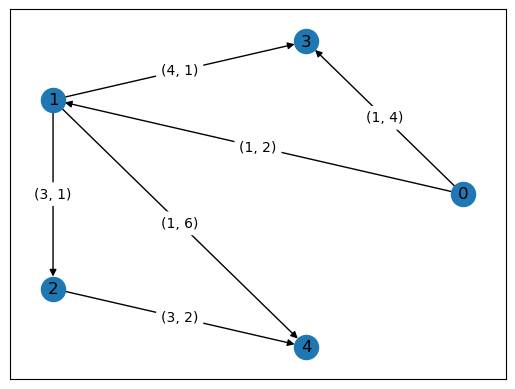

In [17]:
task_medium = Graph()
task_medium.read_from_file("../testdata/bdijkstra/easy/easy_task.txt")
task_medium.print_graph()
sols, good_paths, discarded_paths = BDijkstra(task_medium, 1, SearchTreePQD)
visualize_graph(task_medium.graph)

## Test Medium

![](../testdata/bdijkstra/medium/medium.png)

  V1 -> V2  :  C1, C2
   0 -> 1   :   1, 1
   1 -> 5   :   1, 5
   1 -> 4   :   4, 2
   1 -> 2   :   1, 3
   4 -> 2   :   1, 2
   2 -> 5   :   5, 1
   2 -> 3   :   1, 1


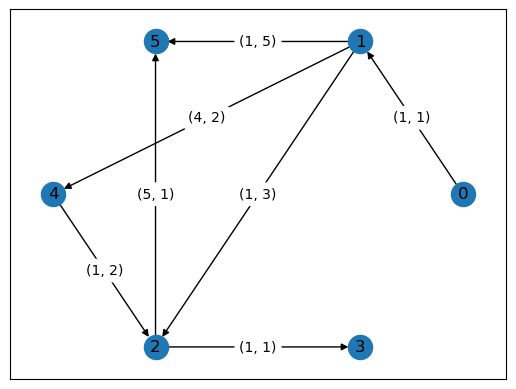

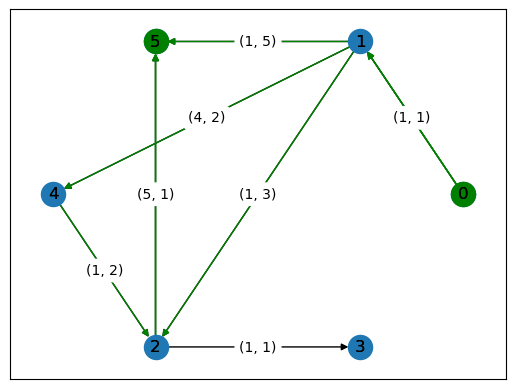

In [19]:
task_medium = Graph()
task_medium.read_from_file("../testdata/bdijkstra/medium/medium_task.txt")
task_medium.print_graph()
sols, good_paths, s = BDijkstra(task_medium, 0, SearchTreePQD)
visualize_graph(task_medium.graph)
visualize_path(task_medium.graph, 0, 5, good_paths[5])

In [21]:
from IPython.display import display
from ipywidgets import Dropdown

dropdown1 = Dropdown(
    options=[('Красный', 1), ('Желтый', 2), ('Зеленый', 3)],
    value=2, # Выбор по умолчанию
    description='Цвет:' 
)

def on_button_clicked(b):
    print(b['old'], '->', b['new'])

dropdown1.observe(on_button_clicked, names='value')
display(dropdown1)

Dropdown(description='Цвет:', index=1, options=(('Красный', 1), ('Желтый', 2), ('Зеленый', 3)), value=2)

2 -> 1
1 -> 3


In [22]:
import networkx as nx
import matplotlib.pyplot as plt
from ipywidgets import interact, widgets

# Создаем пример графа
G = nx.Graph()
G.add_edges_from([(1, 2), (2, 3), (3, 4), (4, 1), (1, 5)])

# Функция для визуализации графа с маршрутом
def plot_graph(start_node, end_node, good_paths, bad_paths):
    pos = nx.spring_layout(G)  # Вы можете выбрать другой способ размещения вершин

    # Отмечаем вершины, входящие в хороший маршрут
    good_nodes = set()
    for path in good_paths:
        good_nodes.update(path)

    # Отмечаем вершины, входящие в плохой маршрут
    bad_nodes = set()
    for path in bad_paths:
        bad_nodes.update(path)

    # Рисуем вершины и ребра
    nx.draw(G, pos, with_labels=True, font_weight='bold', node_color='lightgray')
    
    # Выделяем вершины хороших и плохих маршрутов
    nx.draw_networkx_nodes(G, pos, nodelist=good_nodes, node_color='green')
    nx.draw_networkx_nodes(G, pos, nodelist=bad_nodes, node_color='red')

    # Рисуем маршрут от start_node к end_node
    path = nx.shortest_path(G, source=start_node, target=end_node)
    edges = list(zip(path, path[1:]))
    nx.draw_networkx_edges(G, pos, edgelist=edges, edge_color='blue', width=2)

    plt.show()

# Создаем интерактивные элементы
start_node_dropdown = widgets.Dropdown(
    options=list(G.nodes),
    value=list(G.nodes)[0],
    description='Start Node:'
)

end_node_dropdown = widgets.Dropdown(
    options=list(G.nodes),
    value=list(G.nodes)[1],
    description='End Node:'
)

good_paths_text = widgets.Text(
    placeholder='Enter good paths (e.g., 1-2-3, 1-4-3)',
    description='Good Paths:'
)

bad_paths_text = widgets.Text(
    placeholder='Enter bad paths (e.g., 2-3-4, 1-5-2)',
    description='Bad Paths:'
)

# Создаем функцию, которая будет вызываться при изменении значений интерактивных элементов
def update_plot(start_node, end_node, good_paths_text, bad_paths_text):
    # Преобразуем текстовые данные в списки
    good_paths = [list(map(int, path.split('-'))) for path in good_paths_text.split(',')]
    bad_paths = [list(map(int, path.split('-'))) for path in bad_paths_text.split(',')]

    # Визуализируем граф
    plot_graph(start_node, end_node, good_paths, bad_paths)

# Устанавливаем функцию обновления
interact(update_plot, start_node=start_node_dropdown, end_node=end_node_dropdown,
         good_paths_text=good_paths_text, bad_paths_text=bad_paths_text)

interactive(children=(Dropdown(description='Start Node:', options=(1, 2, 3, 4, 5), value=1), Dropdown(descript…

<function __main__.update_plot(start_node, end_node, good_paths_text, bad_paths_text)>